# Master's Thesis Experiments Report

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image, ImageChops

from scripts.utils import load_latency_data, load_frame_size_data, clean_latency_data, load_precision_data

In [2]:
# constants
FIG_DIR = './figures/{}'
OUT_DIR = './data/out'
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

## 1.   Pipeline Latency
The data was replayed at 8 Mbps.
For each frame f, we measure the timedelta between the last emitted LiDAR data packet and
the last incoming Palicus data packet containing data associated with f.
We exclude the first and the last frame to ensure that we only consider the latency of full frames.

In [3]:
fig_dir = FIG_DIR.format('latency')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [4]:
# Load the data
df_conversion = load_latency_data(pipeline='conversion')
df_roi = load_latency_data(pipeline='roi')
df_dm1 = load_latency_data(pipeline='dm1')
df_dm2 = load_latency_data(pipeline='dm2')
df_bev = load_latency_data(pipeline='bev')

In [5]:
# tabular representation
l = 'latency [ms]'

results = [['min', df_conversion.min()[l], df_roi.min()[l], df_dm1.min()[l], df_dm2.min()[l], df_bev.min()[l]],
           ['mean', df_conversion.mean()[l], df_roi.mean()[l], df_dm1.mean()[l], df_dm2.mean()[l], df_bev.mean()[l]],
           ['median', df_conversion.median()[l], df_roi.median()[l], df_dm1.median()[l], df_dm2.median()[l],
            df_bev.median()[l]],
           ['max', df_conversion.max()[l], df_roi.max()[l], df_dm1.max()[l], df_dm2.max()[l], df_bev.max()[l]]
           ]

df_latency_results = pd.DataFrame(results, columns=['', 'CONV', 'RoI', 'DM (1)', 'DM (2)', 'BEV'])
print(df_latency_results)


               CONV       RoI    DM (1)    DM (2)        BEV
0     min  0.197800  0.191800  0.190600  0.189600   0.298000
1    mean  0.390621  0.393498  0.393449  0.392682  46.147741
2  median  0.300200  0.298000  0.298000  0.297600  47.711000
3     max  1.605600  1.603000  1.582800  1.617200  47.828400


C:\Users\sophi\AppData\Local\Temp\ipykernel_27336\2474037712.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(df_conversion['latency [us]'].to_numpy(), positions=[2], widths=[1],
C:\Users\sophi\AppData\Local\Temp\ipykernel_27336\2474037712.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(df_roi['latency [us]'].to_numpy(), positions=[4], widths=[1],
C:\Users\sophi\AppData\Local\Temp\ipykernel_27336\2474037712.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(df_dm1['latency [us]'].to_numpy(), positions=[6], widths=[1],
C:\Users\sophi\AppData\Local\Temp\ipykernel_27336\24740377

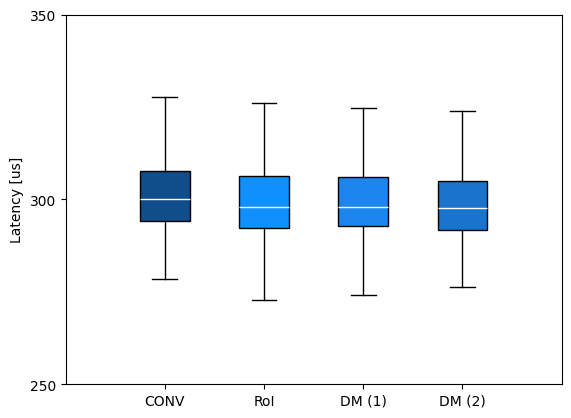

In [6]:
# computation time: conversion vs. RoI vs. DepthMap
df_conversion['latency [us]'] = df_conversion['latency [ms]'] * 1000
df_roi['latency [us]'] = df_roi['latency [ms]'] * 1000
df_dm1['latency [us]'] = df_dm1['latency [ms]'] * 1000
df_dm2['latency [us]'] = df_dm2['latency [ms]'] * 1000

fig, ax = plt.subplots()
ax.boxplot(df_conversion['latency [us]'].to_numpy(), positions=[2], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['CONV'],
           boxprops={'facecolor': '#104E8B'}, medianprops={'color': 'white'})
ax.boxplot(df_roi['latency [us]'].to_numpy(), positions=[4], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['RoI'], 
           boxprops={'facecolor': '#1090FF'}, medianprops={'color': 'white'})
ax.boxplot(df_dm1['latency [us]'].to_numpy(), positions=[6], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['DM (1)'], 
           boxprops={'facecolor': '#1C86EE'}, medianprops={'color': 'white'})
ax.boxplot(df_dm2['latency [us]'].to_numpy(), positions=[8], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['DM (2)'], 
           boxprops={'facecolor': '#1874CD'}, medianprops={'color': 'white'})
ax.set(xlim=(0, 10))
ax.set(ylim=(250, 350), yticks=[250 + i * 50 for i in range(3)], ylabel='Latency [us]')
plt.show()
fig.savefig(os.path.join(fig_dir, 'conv_roi_dm.png'))

C:\Users\sophi\AppData\Local\Temp\ipykernel_27336\1234596885.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(df_bev['latency [ms]'].to_numpy(), positions=[2], widths=[1],


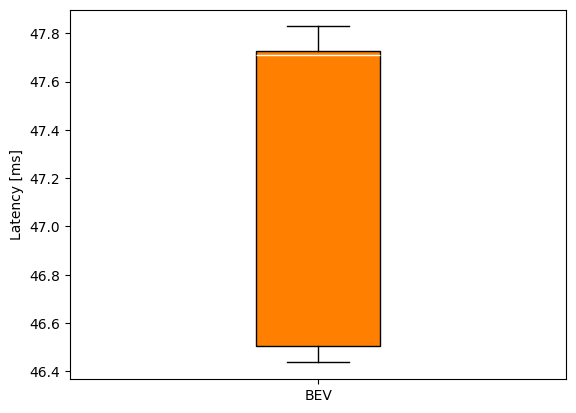

In [7]:
# computation time: BEV vs. MAX
fig, ax = plt.subplots()
ax.boxplot(df_bev['latency [ms]'].to_numpy(), positions=[2], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['BEV'], 
           boxprops={'facecolor': '#FF7F00'}, medianprops={'color': 'white'})
ax.set(xlim=(0, 4))
ax.set(ylabel='Latency [ms]')
plt.show()
fig.savefig(os.path.join(fig_dir, 'bev.png'))

### Latency Impact of PEs

In [8]:
CONV_OUTLIER_FRAMES = df_conversion.loc[df_conversion['latency [ms]'] > 1.0, 'frame_nr'].to_numpy()
ROI_OUTLIER_FRAMES = df_roi.loc[df_roi['latency [ms]'] > 1.0, 'frame_nr'].to_numpy()
BEV_OUTLIER_FRAMES = df_bev.loc[df_bev['latency [ms]'] < 1.0, 'frame_nr'].to_numpy()

FPE_EXCLUDE_FRAMES = np.concat([np.setdiff1d(CONV_OUTLIER_FRAMES, ROI_OUTLIER_FRAMES), np.setdiff1d(ROI_OUTLIER_FRAMES, CONV_OUTLIER_FRAMES)])
AGGPE_EXCLUDE_FRAMES = np.concat([ROI_OUTLIER_FRAMES, BEV_OUTLIER_FRAMES])

In [9]:
ftr = 'diff'


# FPE - impact in [us]
df_1 = df_conversion.rename(columns={'latency [us]': 'CONV'})
df_1 = df_1.loc[:, ['frame_nr', 'CONV']]
for f in FPE_EXCLUDE_FRAMES:
    df_1 = df_1.loc[df_1['frame_nr'] != f]

df_2 = df_roi.rename(columns={'latency [us]': 'RoI'})
df_2 = df_2.loc[:, ['frame_nr', 'RoI']]

# FPE - impact in [us]
df_compare_fpe = pd.merge(df_1, df_2, how='inner', on='frame_nr')
df_compare_fpe[ftr] = df_compare_fpe['RoI'] - df_compare_fpe['CONV']

res_table = [['FPE [us]', df_compare_fpe.min()[ftr], df_compare_fpe.mean()[ftr], df_compare_fpe.median()[ftr], df_compare_fpe.max()[ftr]]]



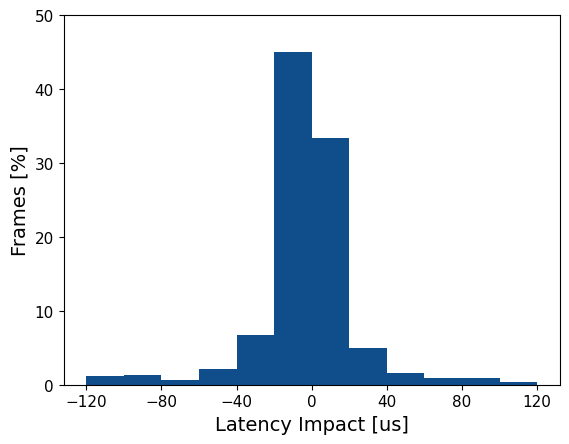

In [10]:
# visualize - histogram
FPE_BINS = [i*20 - 120 for i in range(13)]
fpe_counts, _ = np.histogram(df_compare_fpe[ftr].to_numpy(), bins=FPE_BINS)
fpe_counts = fpe_counts / len(df_1) * 100

fig, ax = plt.subplots()
ax.hist(FPE_BINS[:-1], FPE_BINS, weights=fpe_counts, label='RoI - CONV', color='#104E8B')
ax.set(xticks=[i*40 - 120 for i in range(7)],
       yticks=[i*10 for i in range(6)])

ax.set_xlabel('Latency Impact [us]', fontsize=14)
ax.set_ylabel('Frames [%]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=11)
plt.show()
fig.savefig(os.path.join(fig_dir, 'fpe_impact_hist.png'))

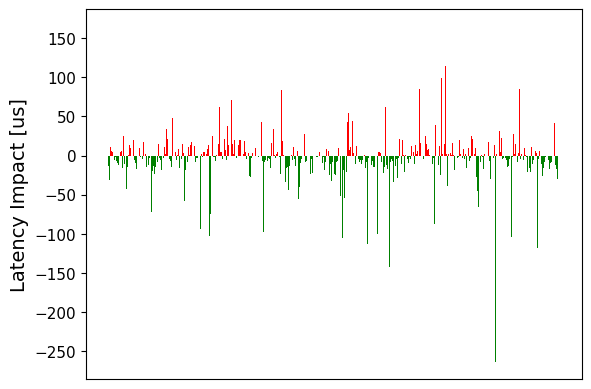

In [11]:
# visualize - per frame
df_compare_fpe.sort_values(by='frame_nr', ascending=True)
labels = df_compare_fpe.loc[:, 'frame_nr'].to_numpy()
data = df_compare_fpe.loc[:, ftr].to_numpy()
fig, ax = plt.subplots()
ax.bar(x=labels, height=data, color=['green' if i <= 0 else 'red' for i in data])
ax.set_ylabel('Latency Impact [us]', fontsize=14)
ax.set(xticks=[])
ax.set(yticks=[i*50 - 250 for i in range(9)])
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()
fig.savefig(os.path.join(fig_dir, 'fpe_impact_bar.png'))

In [12]:
# ArPE - impact in [us]

df_3 = df_dm1.rename(columns={'latency [us]': 'DM (1)'})
df_3 = df_3.loc[:, ['frame_nr', 'DM (1)']]

df_4 = df_dm2.rename(columns={'latency [us]': 'DM (2)'})
df_4 = df_4.loc[:, ['frame_nr', 'DM (2)']]
    
df_compare_arpe = pd.merge(df_2, df_3, how='inner', on='frame_nr')
df_compare_arpe[ftr] = df_compare_arpe['DM (1)'] - df_compare_arpe['RoI']

res_table.append(['ArPE [us]', df_compare_arpe.min()[ftr], df_compare_arpe.mean()[ftr], df_compare_arpe.median()[ftr], df_compare_arpe.max()[ftr]])

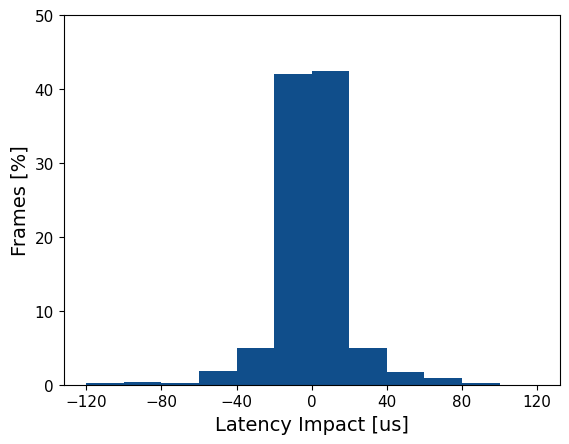

In [13]:
# visualize - histogram
ARPE_BINS = FPE_BINS
arpe_counts, _ = np.histogram(df_compare_arpe[ftr].to_numpy(), bins=ARPE_BINS)
arpe_counts = arpe_counts / len(df_compare_arpe) * 100

fig, ax = plt.subplots()
ax.hist(ARPE_BINS[:-1], ARPE_BINS, weights=arpe_counts, label='DM (1) - RoI', color='#104E8B')
ax.set(xticks=[i*40-120 for i in range(7)],
       yticks=[i*10 for i in range(6)])
ax.set_xlabel('Latency Impact [us]', fontsize=14)
ax.set_ylabel('Frames [%]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=11)
plt.show()
fig.savefig(os.path.join(fig_dir, 'arpe_impact_hist.png'))

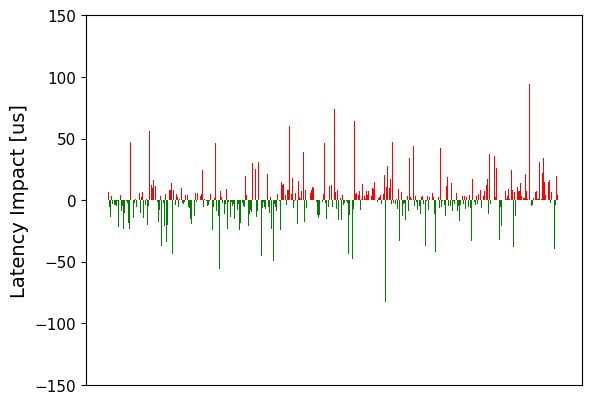

In [14]:
df_compare_arpe.sort_values(by='frame_nr', inplace=True)
labels = df_compare_arpe.loc[:, 'frame_nr'].to_numpy()
data = df_compare_arpe.loc[:, ftr].to_numpy()

fig, ax = plt.subplots()
ax.bar(x=labels, height=data, color=['green' if i <= 0 else 'red' for i in data])
ax.set_ylabel('Latency Impact [us]', fontsize=14)
ax.set(xticks=[])
ax.set(yticks=[i*50 - 150 for i in range(7)])
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()
fig.savefig(os.path.join(fig_dir, 'arpe_impact_bar.png'))




In [15]:
# AggPE - [ms]
df_5 = df_bev.rename(columns={'latency [ms]': 'BEV'})
df_5 = df_5.loc[:, ['frame_nr', 'BEV']]
for f in AGGPE_EXCLUDE_FRAMES:
    df_5 = df_5.loc[df_5['frame_nr'] != f]

df_4['DM (2)'] /= 1000 # convert to ms

df_compare_aggpe = pd.merge(df_4, df_5, how='inner', on='frame_nr')
df_compare_aggpe[ftr] = df_compare_aggpe['BEV'] - df_compare_aggpe['DM (2)']

res_table.append(['AggPE [ms]', df_compare_aggpe.min()[ftr], df_compare_aggpe.mean()[ftr], df_compare_aggpe.median()[ftr], df_compare_aggpe.max()[ftr]])

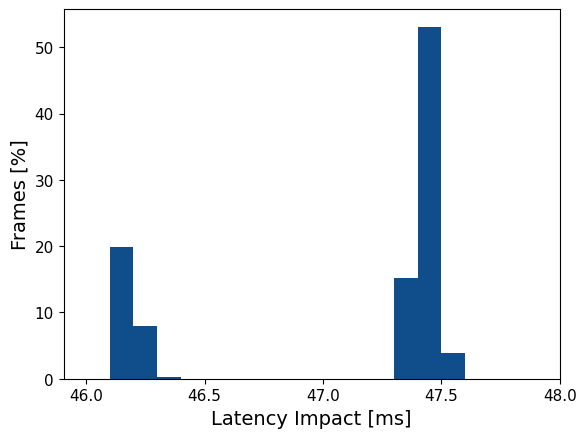

In [30]:
# visualize - histogram
AGG_BINS = [46 + i / 10  for i in range(20)]
aggpe_counts, aggpe_bins = np.histogram(df_compare_aggpe[ftr].to_numpy(), bins=AGG_BINS)
aggpe_counts = aggpe_counts / len(df_compare_aggpe) * 100

fig, ax = plt.subplots()
ax.hist(AGG_BINS[:-1], AGG_BINS, weights=aggpe_counts, label='AggPE', color='#104E8B')
ax.set(xticks=[i*0.5 + 46 for i in range(5)])

ax.set_xlabel('Latency Impact [ms]', fontsize=14)
ax.set_ylabel('Frames [%]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=11)
plt.show()
fig.savefig(os.path.join(fig_dir, 'aggpe_impact_hist.png'))

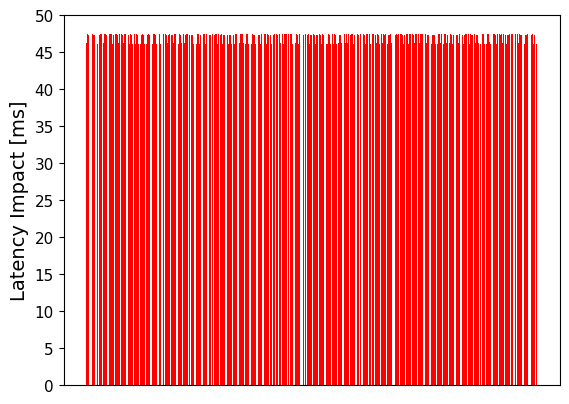

In [17]:
# visualize - bar
df_compare_aggpe.sort_values(by='frame_nr', inplace=True)
labels = df_compare_aggpe.loc[:, 'frame_nr'].to_numpy()
data = df_compare_aggpe.loc[:, ftr].to_numpy()

fig, ax = plt.subplots()
ax.bar(x=labels, height=data, color=['green' if i <= 0 else 'red' for i in data])
ax.set_ylabel('Latency Impact [ms]', fontsize=14)
ax.set(xticks=[])
ax.set(yticks=[i*5 for i in range(11)])
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()
fig.savefig(os.path.join(fig_dir, 'aggpe_impact_bar.png'))

In [18]:
# raw numbers
df_res = pd.DataFrame(res_table, columns=['', 'min', 'mean', 'median', 'max'])
print(df_res)

                    min       mean   median       max
0    FPE [us] -263.8000  -3.561390  -2.5000  165.2000
1   ArPE [us] -106.8000  -0.048762   0.0000   94.0000
2  AggPE [ms]   46.1418  47.079505  47.4084   47.5284


#### Impact of FPE on Frame Size

In [19]:
# Conversion
conv_elements = load_frame_size_data(pipeline='conversion')
# RoI
roi_elements = load_frame_size_data(pipeline='roi')


df_compare_elements = pd.concat([conv_elements.loc[:, 'n_elements'].rename('CONV'),
                                roi_elements.loc[:, 'n_elements'].rename('RoI')], axis=1)
df_compare_elements['ratio'] = df_compare_elements['RoI'] / df_compare_elements['CONV'] * 100

print('min\t\t', df_compare_elements.min()['ratio'])
print('mean\t', df_compare_elements.mean()['ratio'])
print('median\t', df_compare_elements.median()['ratio'])
print('max\t\t', df_compare_elements.max()['ratio'])

min		 95.36396346526432
mean	 95.55547517144353
median	 95.55843706777317
max		 95.65698478561549


In [20]:
# Number of outlier frames
conv_num_outliers = len(df_conversion.loc[df_conversion['latency [ms]'] > 1])
roi_num_outliers = len(df_roi.loc[df_roi['latency [ms]'] > 1])
dm1_num_outliers = len(df_dm1.loc[df_dm1['latency [ms]'] > 1])
dm2_num_outliers = len(df_dm2.loc[df_dm2['latency [ms]'] > 1])
print(conv_num_outliers, roi_num_outliers, dm1_num_outliers, dm2_num_outliers)

39 42 42 42


## 2. Point Rate

In [21]:
# load the ground truth
all_gt = pd.read_csv('./data/conversion/point_rate/frame_size_gt.csv').sum()['n_elements']
filtered_gt = pd.read_csv('./data/roi/point_rate/frame_size_gt.csv').sum()['n_elements']
bev_gt = pd.read_csv('./data/bev/point_rate/frame_size_gt.csv').sum()['n_elements']

print(all_gt, filtered_gt, bev_gt)

30381904 29031584 133378


In [22]:
# overview
total_elem = []
cols = ['Pipeline', 'GT', '8Mbps', '16Mbps', '32Mbps', '64Mbps', '128Mbps']
for p in ['conversion', 'roi', 'dm1', 'dm2', 'bev']:
    gt = all_gt if p == 'conversion' else bev_gt if p == 'bev' else filtered_gt
    log = [p, gt]
    for t in [8, 16, 32, 64, 128]:
        df = load_frame_size_data(pipeline=p, throughput=t)
        total = df.sum()['n_elements']
        log.append(total)
    total_elem.append(log)

df_res = pd.DataFrame(np.array(total_elem), columns=cols)
df_res.to_csv(os.path.join(OUT_DIR, 'throughput_overview.csv'), index=False)
print(df_res)

     Pipeline        GT     8Mbps    16Mbps    32Mbps    64Mbps   128Mbps
0  conversion  30381904  30381904  30381904  30381904  30371152  30381904
1         roi  29031584  29031573  29031573  29030424  29006738  29026604
2         dm1  29031584  29031573  29031573  29031573  29031573  29031190
3         dm2  29031584  29031573  29031573  28965945  29031573  29031573
4         bev    133378    139197    139197    139197    139197    139196


## 3. Precision

In [23]:
# Pipeline 1: RoI


In [24]:
# --- visualize --- #
# ToDo



In [25]:
# Pipeline 2: BEV - max(z)


In [26]:
# --- visualize --- #
gt_img = Image.open('./figures/precision/bev/000080/ground_truth.png')
pal_img = Image.open('./figures/precision/bev/000080/palicus.png')
diff = ImageChops.difference(gt_img, pal_img)
diff.save('./figures/precision/bev/000080/delta.png')

display(gt_img)
display(pal_img)
display(diff)

In [27]:
# Pipeline 3: BEV - mean(i)

In [28]:
# --- visualize --- #
gt_img = Image.open('./figures/precision/bev_mean/000522/ground_truth.png')
pal_img = Image.open('./figures/precision/bev_mean/000522/palicus.png')
diff = ImageChops.difference(gt_img, pal_img)
diff.save('./figures/precision/bev_mean/000522/delta.png')

display(gt_img)
display(pal_img)
display(diff)